# Задание 2: регрессия на синтетическом датасете

In [1]:
# Импортируем необходимые библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import phik
RANDOM_STATE = 42
TEST_SIZE = 0.20

## Генерация данных

Сгенерируем датасет, содержащий 1000 наблюдений и 10 признаков.

In [2]:
# Параметры датасета
np.random.seed(RANDOM_STATE)
n_samples, n_features = 1000, 10

# Генерируем случайные признаки с целевой переменной - линейной комбинацией признаков с добавлением гауссовского шума
X = np.random.randn(n_samples, n_features)
coefficients = np.random.randn(n_features)
y = X @ coefficients + np.random.randn(n_samples) * 0.1

In [3]:
# Создаем датафрейм с данными
feature_names = [f'feature_{i+1}' for i in range(n_features)]
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

## Разделение данных:

Разделим датасет на тренировочную и тестовую выборки в соотношении 80:20.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [5]:
# Проверим разбиение
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((800, 10), (800,), (200, 10), (200,))

## Построение модели

Построим модель с использованием бэггинга, где базовым алгоритмом будет линейная регрессия.

In [6]:
# Создаем бэггинг-модель
bagging_lr = BaggingRegressor(estimator=LinearRegression())
bagging_lr.fit(X_train, y_train)

,"estimator estimator: object, default=NoneThe base estimator to fit on random subsets of the dataset.If None, then the base estimator is a:class:`~sklearn.tree.DecisionTreeRegressor`... versionadded:: 1.2 `base_estimator` was renamed to `estimator`.",LinearRegression()
,"n_estimators n_estimators: int, default=10The number of base estimators in the ensemble.",10
,"max_samples max_samples: int or float, default=NoneThe number of samples to draw from X to train each base estimator (withreplacement by default, see `bootstrap` for more details).- If None, then draw `X.shape[0]` samples irrespective of `sample_weight`.- If int, then draw `max_samples` samples.- If float, then draw `max_samples * X.shape[0]` unweighted samples or `max_samples * sample_weight.sum()` weighted samples.",None
,"max_features max_features: int or float, default=1.0The number of features to draw from X to train each base estimator (without replacement by default, see `bootstrap_features` for moredetails).- If int, then draw `max_features` features.- If float, then draw `max(1, int(max_features * n_features_in_))` features.",1.0
,"bootstrap bootstrap: bool, default=TrueWhether samples are drawn with replacement. If False, sampling withoutreplacement is performed. If fitting with `sample_weight`, it isstrongly recommended to choose True, as only drawing with replacementwill ensure the expected frequency semantics of `sample_weight`.",True
,"bootstrap_features bootstrap_features: bool, default=FalseWhether features are drawn with replacement.",False
,"oob_score oob_score: bool, default=FalseWhether to use out-of-bag samples to estimatethe generalization error. Only available if bootstrap=True.",False
,"warm_start warm_start: bool, default=FalseWhen set to True, reuse the solution of the previous call to fitand add more estimators to the ensemble, otherwise, just fita whole new ensemble. See :term:`the Glossary `.",False
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for both :meth:`fit` and:meth:`predict`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the random resampling of the original dataset(sample wise and feature wise).If the base estimator accepts a `random_state` attribute, a differentseed is generated for each instance in the ensemble.Pass an int for reproducible output across multiple function calls.See :term:`Glossary `.",None
,"verbose verbose: int, default=0Controls the verbosity when fitting and predicting.",0


## Оценка качества модели

Оценим качество модели на тестовой выборке, используем MSE и R2.

In [7]:
y_pred = bagging_lr.predict(X_test)
print(f'Метрика MSE на тестовой выборке: {mean_squared_error(y_test, y_pred):.4f}')
print(f'Метрика R2 на тестовой выборке: {r2_score(y_test, y_pred):.4f}')

Метрика MSE на тестовой выборке: 0.0093
Метрика R2 на тестовой выборке: 0.9985


**MSE = 0.009** - чрезвычайно низкое значение, выдающийся результат.

**R2 = 0.99** - в 99% случаев предсказание модели ближе к истине, чем среднее значение целевого признака. Это уровень, характерный скорее для физических законов или точно смоделированных данных.

## Анализ

#### Корреляционный анализ признаков

Изучим взаимосвязь между признаками: рассчитаем коэффициенты корреляции между всеми признаками и построим тепловую карту.

In [8]:
# Вычисление матрицы корреляции 
corr = df.corr()

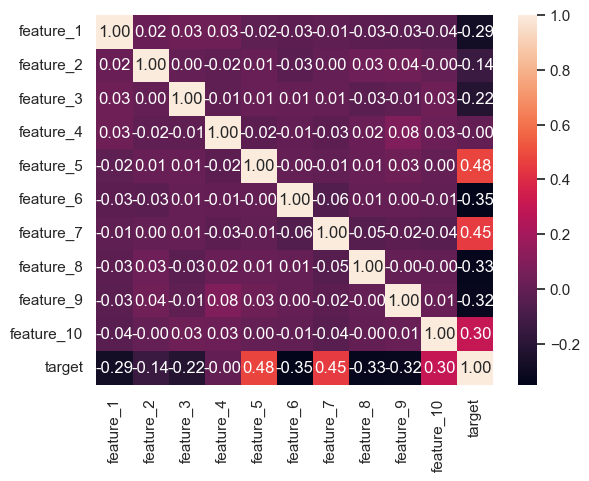

In [9]:
# Построение тепловой карты
sns.heatmap(corr, annot=True, fmt='.2f');

**Мультиколлинеарность** между входными признаками **не наблюдается**, коэффициент корреляции от 0.9 до 0.95 по модулю отсутствует.

Мы наблюдаем умеренную прямую связь между целевым и 5,6 признаком, слабую обратную связь между целевым и 1, 2, 3, 6, 8, 9, а также слабую прямую связт между целевыми и 10, отсутствие связи между целевыми и 4.

### Анализ остатков 

Проведем анализ остатков

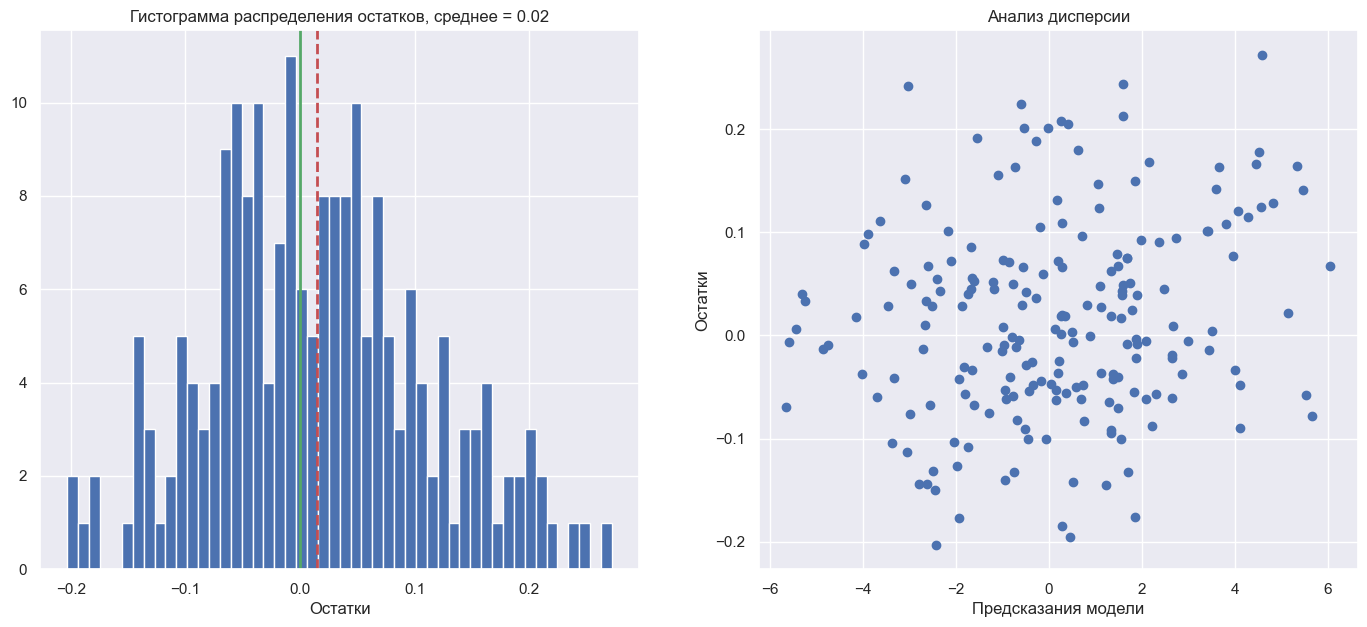

In [10]:
# Рассчитаем остатки
residuals = y_test-y_pred

# построим графики по количественным признакам — гистограмму частотности 
# распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17,7))
axes[0].hist(residuals, bins=50)
axes[0].axvline(x=residuals.mean(), color='r', linestyle='--', linewidth=2)
axes[0].axvline(x=0, color='g', linestyle='-', linewidth=2)
axes[0].set_title(f'Гистограмма распределения остатков, среднее = {residuals.mean():.2f}')
axes[0].set_xlabel('Остатки')

axes[1].scatter(y_pred, residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

Среднее значение на гистограмме смещено вправо от нуля и равно 0.01 - значит модель дает прогнозы иногда на 0.01 больше истинных значений. 

На диаграмме рассеяния мы не наблюдаем четкую закономерность, значит модель неравномерно ошибается.

### Анализ важности признаков

In [11]:
# Получаем коэффициенты из всех базовых моделей и усредняем
base_models = bagging_lr.estimators_
coefficients_list = [model.coef_ for model in base_models]
mean_coef = np.mean(coefficients_list, axis=0)

# Создадим датафрейм с признаками и их весами
lr_coefficients = pd.DataFrame({
    'Признак': feature_names,
    'Коэффициент': mean_coef,
    'Абсолютное_значение': np.abs(mean_coef)
}).sort_values('Абсолютное_значение', ascending=False)

In [12]:
lr_coefficients.head(10)

,Признак,Коэффициент,Абсолютное_значение
4,feature_5,1.194903,1.194903
6,feature_7,0.999103,0.999103
8,feature_9,-0.848713,0.848713
9,feature_10,0.814238,0.814238
7,feature_8,-0.776062,0.776062
5,feature_6,-0.770085,0.770085
0,feature_1,-0.679083,0.679083
2,feature_3,-0.595022,0.595022
1,feature_2,-0.305562,0.305562
3,feature_4,0.116729,0.116729


Наибольшее влияние на целевую переменную оказывают признаки 5 и 7, имеющие наибольшие по модулю коэффициенты (1.2 и 1 соответственно). Это означает, что рост этих признаков линейно увеличивает значение целевой переменной.

## **Итоговые выводы**

Таким образом мы создали синтетический датасет и обучили на нем модели для задачи регрессии:

1. Построили модель для регрессии.

Для этого были выполнены следующие действия:

- Сгенерирован датасет, содержащий 1000 наблюдений и 2 признака, разделили его на обучающую и тестовую выборку в соотношении 80:20
  
- Обучили модель с использованием бэггинга, в качестве базовой взяли линейную регрессию

- Оценили качество на тесте с помощью метрики MSE и R2:

  MSE = 0.009 - чрезвычайно низкое значение, выдающийся результат.

  R2 = 0.99 - в 99% случаев предсказание модели ближе к истине, чем среднее значение целевого признака. Это уровень, характерный скорее для физических законов или точно смоделированных данных.

- Провели анализ остатков, важности признаков и корреляционный:

    мультиколлинеарность не обнаружена, модель неравномерно и мало ошибается, самыми значимыми для модели оказались признаки 5, 7, 9.